<a href="https://colab.research.google.com/github/ingileif/BI188_Spring_2020/blob/master/Bi188_data_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BI188 Spring 2020 Data Analysis Project : single-cell RNA-seq
In this Python notebook you will read in a count matrix for a 10X Chromium dataset from the Wold Lab.  It contains scRNA-Seq data from mouse limbs early in development.

The count matrix was created with kallisto and bustools, using the command `kb`.  You will performs an analysis of the cell types and their marker genes.

The notebook uses kallisto and bustools to process the data, and SCANPY for analysis.  For more background information see:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0


## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [60]:
%%time
# These packages are pre-installed on Google Colab, but are included 
# here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip3 install leidenalg
!pip install louvain
!pip install scanpy

CPU times: user 130 ms, sys: 83.2 ms, total: 214 ms
Wall time: 19.6 s


### Install kb-python
We have pre-run kallisto bustools to obtain the count matrix.  We do not need to install `kb` so we comment out the commands with # at the beginning of the line.

In [0]:
%%time
# install kb
# !pip install kb-python 

### Download the data
The following commands are used to download `fastqs` files for analysis, since we are starting with a count matrix we can comment them out with a # at the start of the line.


In [0]:
%%time
# Download the data from the 10x website
# !wget [include path to a fastqs file]

# unpack the downloaded files
# !tar -xvf [name of downloaded file]

### Download an index

To generate a count matrix from the `fastqs` file we need an index that describes how to map reads (from the fastqs file) to transcripts (i.e. known mRNA transcripts).  This index is species specific.  In our analysis we comment out this command.

In [0]:
# !kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

## Pseudoalignment and counting

### Run kallisto and bustools
As mentioned above, we have already run `kb` on the fastq files to obtain the count matrix. We show how to run `kb` for completeness.

In [0]:
# %%time
# !kb count --h5ad -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz

### Download the count matrices
To save time in this analysis we have pre-run kallisto bustools and stored the count matrixes locally on a server at Caltech.  We use the command `wget` to download the files.

Our data is stored in the files `adata.h5ad` and `t2g.txt`.  The count data is in the adata file; `h5ad` is a custom file format used for scRNA-Seq data. We need a map from transcripts to genes; that is stored in a text file, `t2g.txt`.  

In [61]:
!wget -O adata.h5ad https://caltech.box.com/shared/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
!wget -O t2g.txt https://caltech.box.com/shared/static/yeeb25mvbl67t6fnehb07mbhq5nlq6kl.txt

--2020-05-19 18:06:36--  https://caltech.box.com/shared/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
Resolving caltech.box.com (caltech.box.com)... 103.116.4.197
Connecting to caltech.box.com (caltech.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad [following]
--2020-05-19 18:06:36--  https://caltech.box.com/public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad [following]
--2020-05-19 18:06:37--  https://caltech.app.box.com/public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
Resolving caltech.app.box.com (caltech.app.box.com)... 103.116.4.199
Connecting to caltech.app.box.com (caltech.app.box.com)|103.116.4.199|:443... connected.
HTTP request sent, awaiting response... 

### Read data into python
We used kallisto to obtain a count matrix but now we install `scanpy` which is a python package for analysis of scRNA-Seq data.  We also install a few python and matlab packages that will be used for data processing and plotting.

To read up on scanpy go to:
https://scanpy.readthedocs.io/en/stable/

In [0]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt


We set a few scanpy parameters.

In [63]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.5.0 anndata==0.7.2 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.0


Earlier we downloaded the data file, `adata.h5ad` and the map `t2g.txt`.  We now read the data from the files into python, and name the variables `adata` and `t2g`.  

We use functions from the package `anndata`, which we imported earlier, to annotate the count matrix, i.e. attach to it information on gene names etc.

In the last line we type the name of the variable, `adata` and the message printed to the screen confirms that we have a data matrix of size 603685 × 55421.  The associated variable `adata.var` contains the a list of `gene_id` to `gene_name`.

In [0]:
# load the unfiltered matrix
results_file = 'adata.h5ad'  # the file that will store the analysis results
adata = anndata.read_h5ad("adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In python you can obtain information on a variable by typing its name.  We type `adata` and get information on how many unique cells and how many genes we have.  Notice the number - I get 603,685 cells and 55,421 genes.  

In [66]:
adata

AnnData object with n_obs × n_vars = 603685 × 55421
    var: 'gene_id', 'gene_name'

In [67]:
adata.X

<603685x55421 sparse matrix of type '<class 'numpy.float32'>'
	with 39280903 stored elements in Compressed Sparse Row format>

The datamatrix will be updated in the section on "Filtering".  In case we want to come back to the original dataset we save a copy.

In [69]:
# Save a copy of the original data
adataOriginal = adata
adataOriginal


AnnData object with n_obs × n_vars = 603685 × 55421
    var: 'gene_id', 'gene_name'

Run only if you want to reset the data object to the original (unfiltered) data.

In [0]:
#del adata
#adata = adataOriginal

## Basic Quality Control
The first step of the analysis is to do basic quality control (QC).  

### Number of UMIs per cell/barcode and number of genes per cell/barcode.


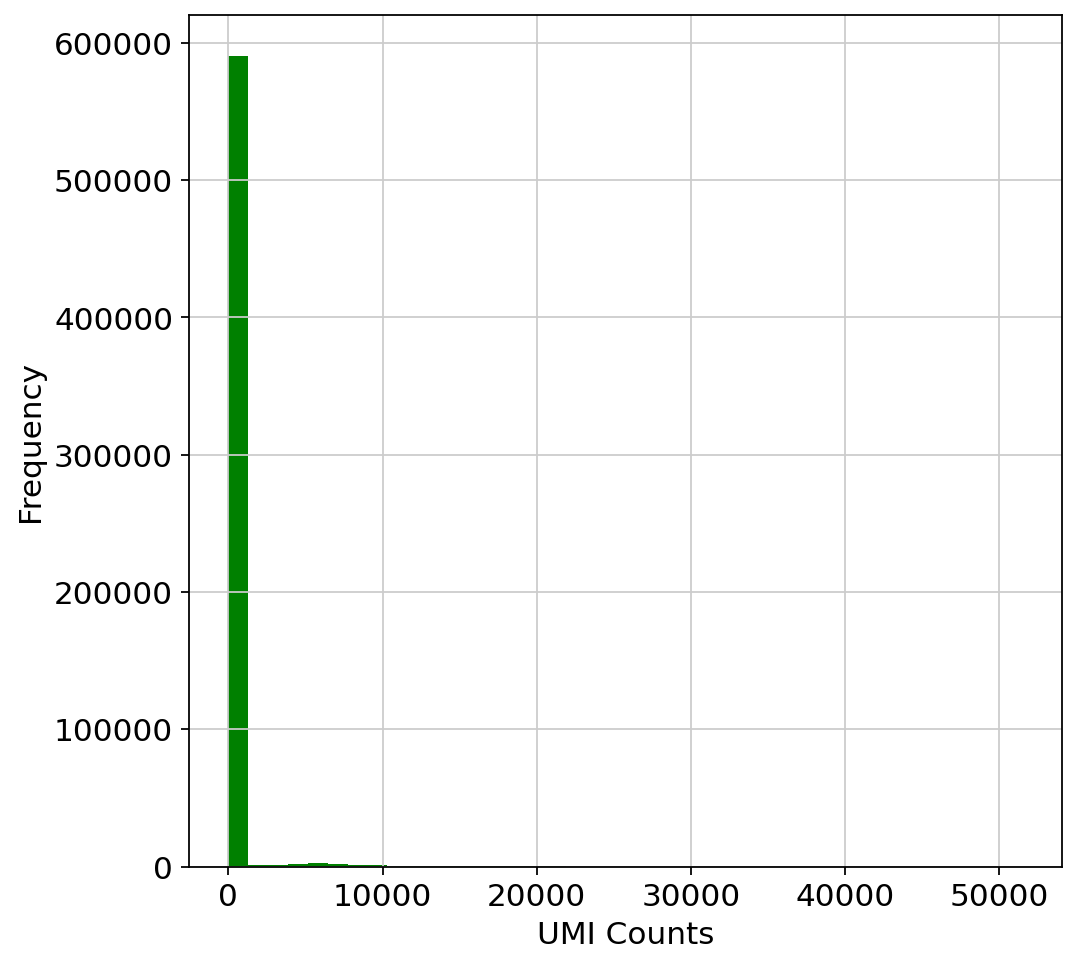

In [70]:
# Histogram of #UMIs per cell.
fig, ax = plt.subplots(figsize=(7, 7))
x = np.asarray(adata.X.sum(axis=1))[:,0]

ax.hist(x, color="green", bins=40)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Frequency")
plt.show()

The histogram is not very informative as is because there are so many cells with zero UMIs that we can't see the shape of the rest of the data.  We redo the histogram, this time cutting off the y-axis at 3000.

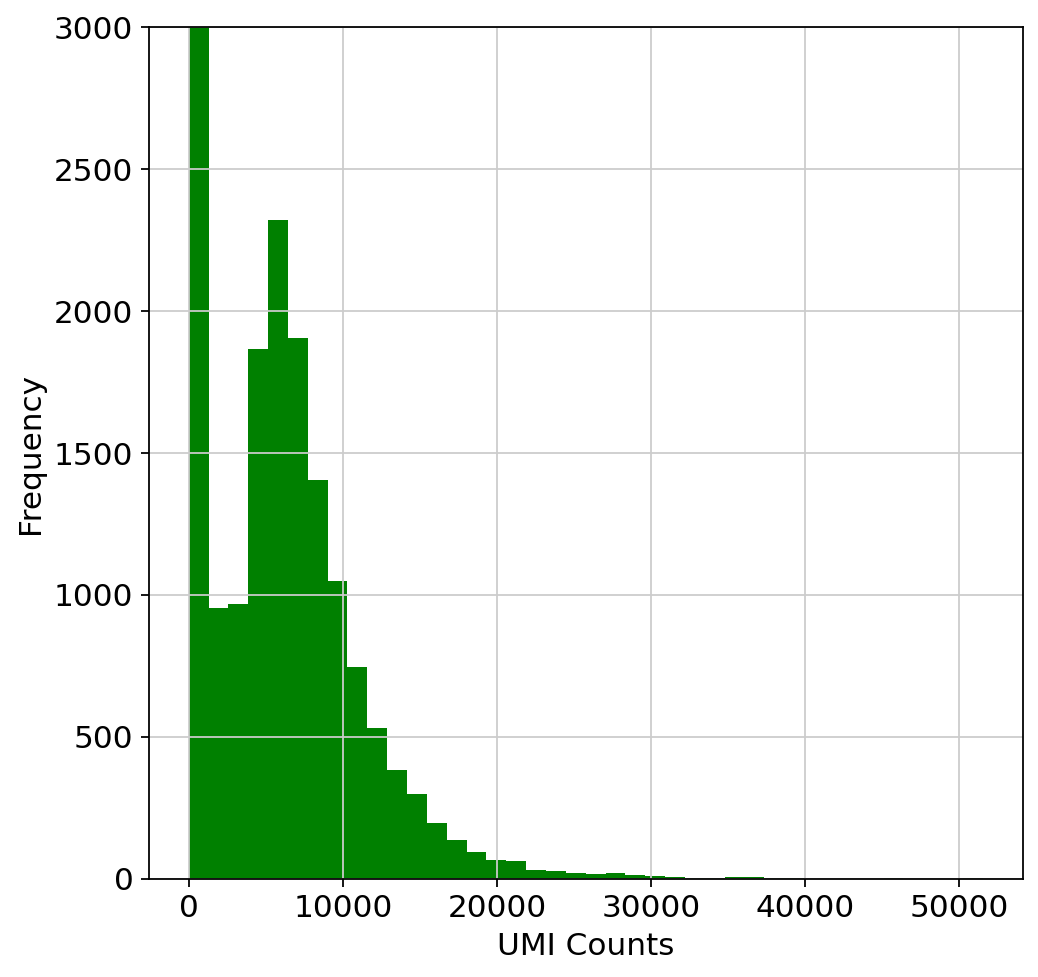

In [71]:
# Histogram of UMI counts, truncated y-axis.
fig, ax = plt.subplots(figsize=(7, 7))
x = np.asarray(adata.X.sum(axis=1))[:,0]

ax.hist(x, color="green", bins=40)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Frequency")
ax.set_ylim(0,3000)
plt.show()

Next we look at the number of genes per cell.

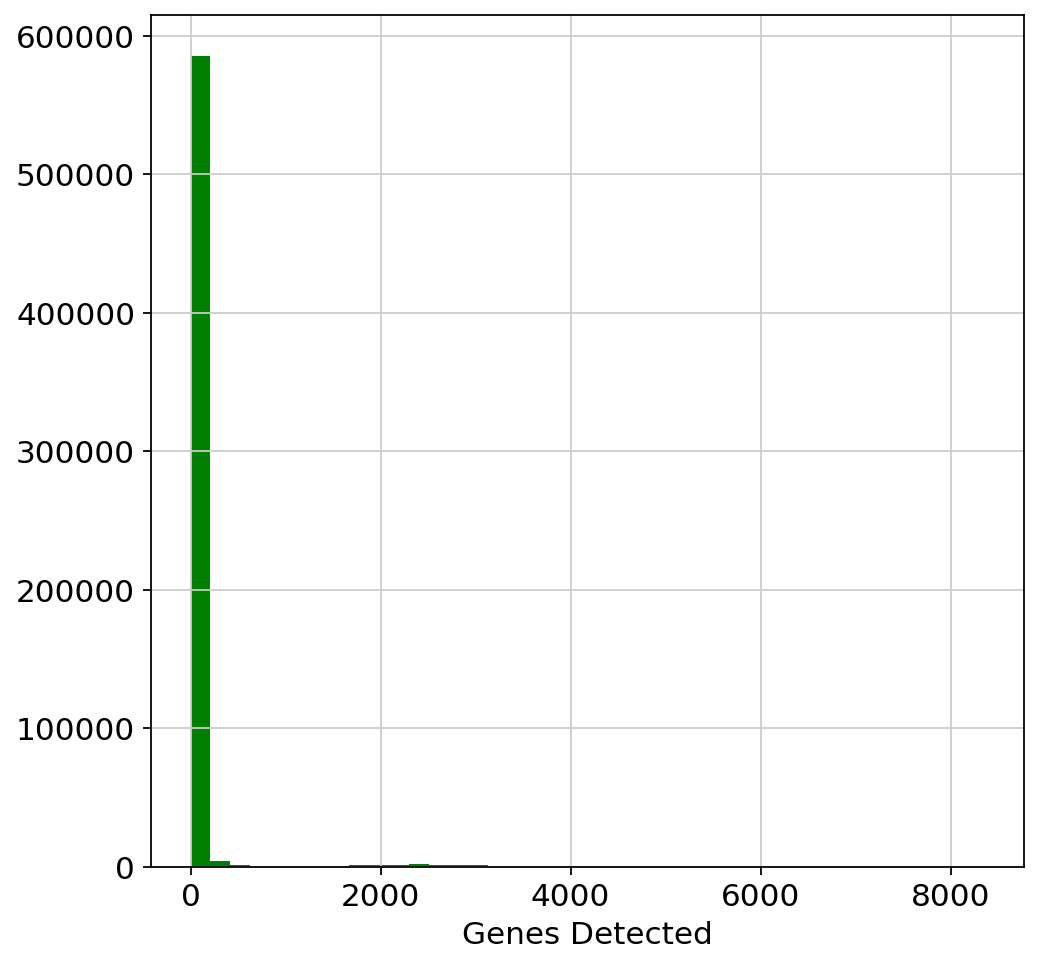

In [72]:
# Histogram of #genes expressed in each cell
fig, ax = plt.subplots(figsize=(7, 7))

y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

# alpha is a plotting parameter that determines how
# transluscent the plotting symbols are
ax.hist(y, color="green", bins=40)
ax.set_xlabel("Genes Detected")
#ax.set_xlim(1)
#ax.set_ylim(1)
plt.show()

#ax.set_ylim(0,3000)


Again, truncate the y-axis:

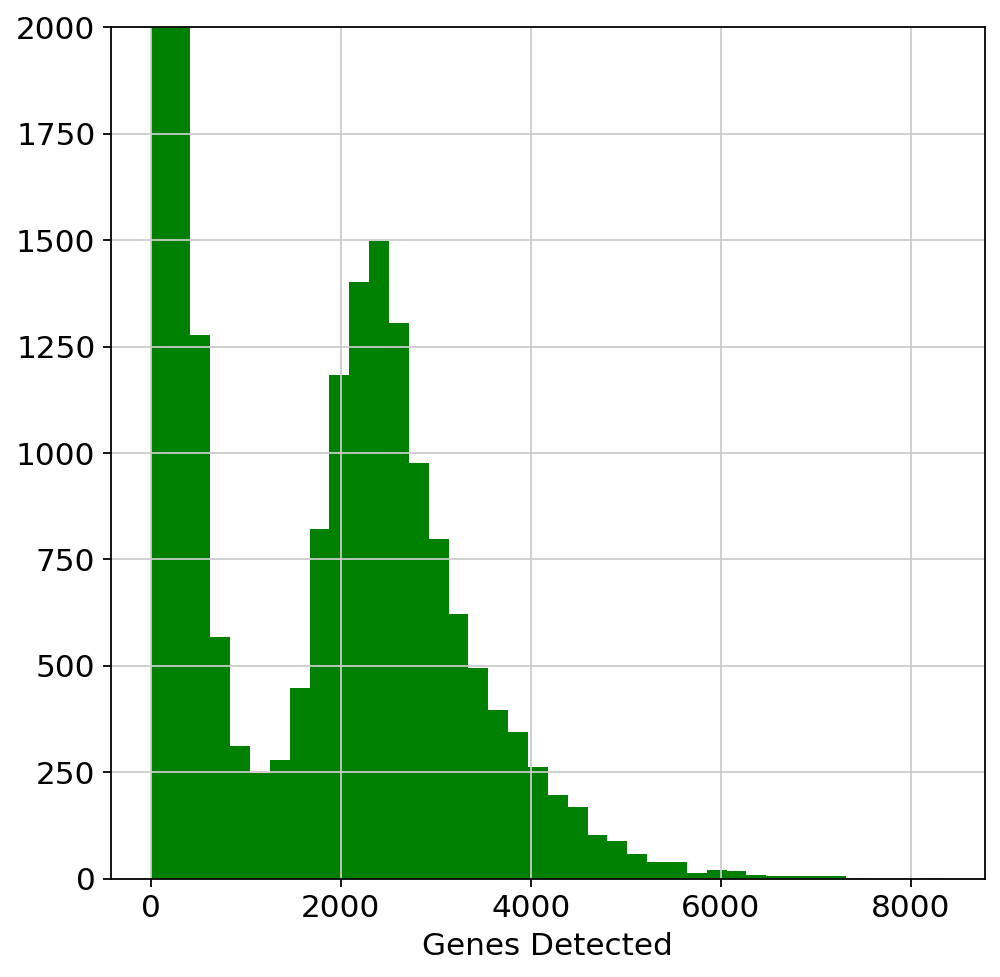

In [73]:
# Histogram of #genes per cell
fig, ax = plt.subplots(figsize=(7, 7))

y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

# alpha is a plotting parameter that determines how
# transluscent the plotting symbols are
ax.hist(y, color="green", bins=40)
ax.set_xlabel("Genes Detected")
ax.set_ylim(0,2000)
plt.show()


### Test for library saturation
We can not sequence the whole library of reads. The library is fully saturated when we have sequenced enough to observe all the distinct mRNAs present in the sample.  The number of UMIs observed in a cell is a function of how much has been sequenced.  It is also a good predictor for how many genes we have observed.  

We plot #genes vs. #UMI per observation.  Note the logarithmic scale on the axes.

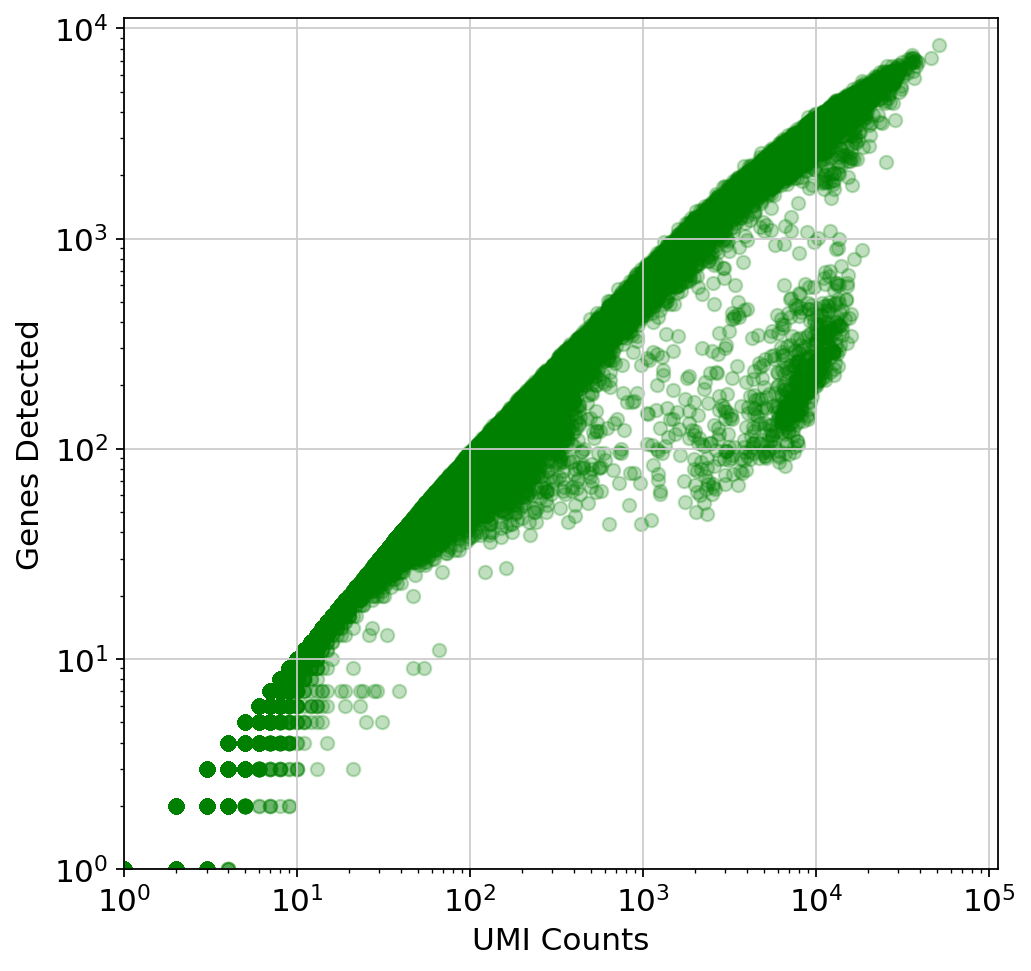

In [74]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(7, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

# alpha is a plotting parameter that determines how
# transluscent the plotting symbols are
ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)


plt.show()

#### Question 
*The bulk of the observations fall close to the line y=x.  All of the outliers are below this line.  Why do you think that is?*

Type your answer here:

*Note the cluster of observations that are separated from, and situated below, the bulk of the data.  What could these 
observations be?*

Type your answer here:



---



This plot is somewhat misleading.  There are on the order of 10^10 points in our dataset.  We have set the translucency plotting parameter alpha=0.25 in order to see a darker color when multiple datapoints are stacked on top of each other, but the color is quickly saturated so in the plot a point with 5 observations and a point with 1000 observations superimposed on each other look the same.

We make a second plot of the same data where we first calculate, at each bin of UMI and #gene value, what fraction of observations are there.  Then we plot this with a color gradient so that the palest green corresponds to points where we have a handful of observations and the darkest points correspond to ~5*10^5 superimposed observarions.

This takes about a minute to run since there are a lot of points.

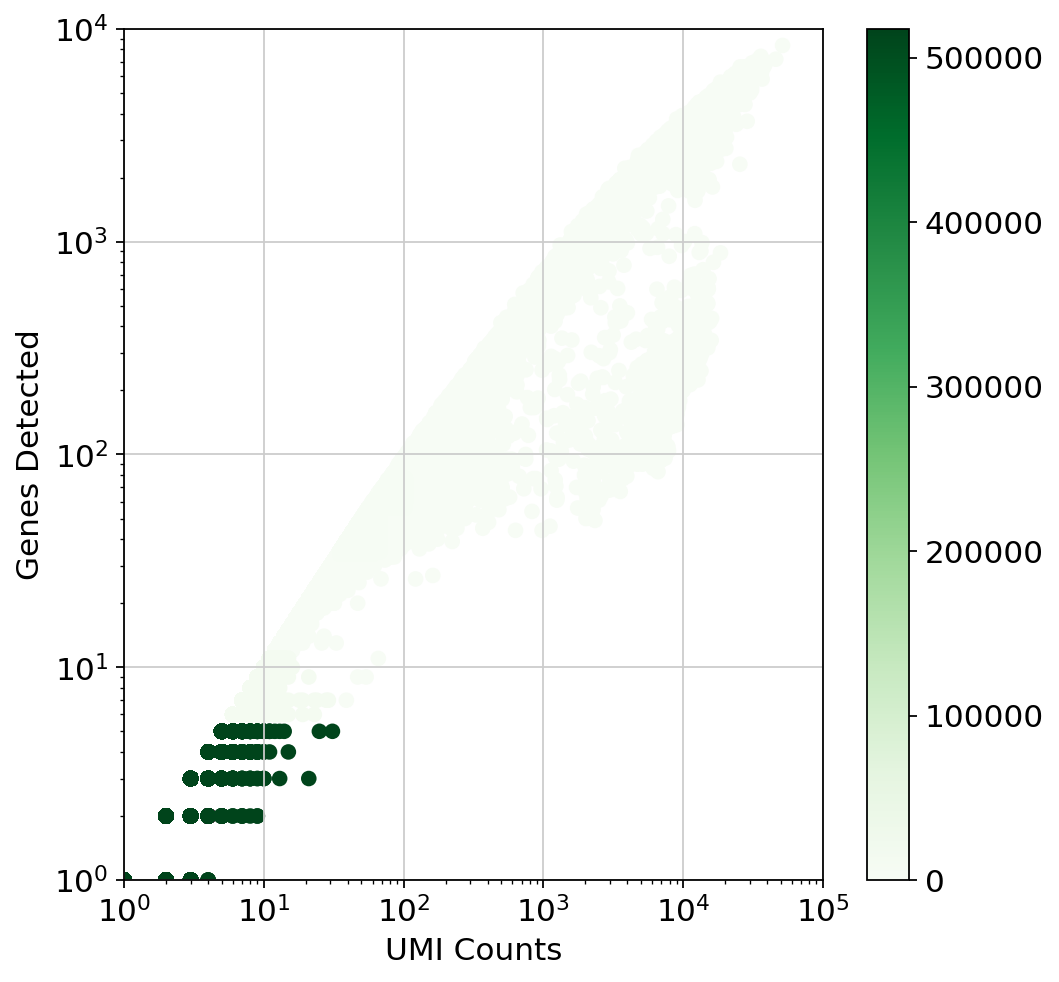

In [75]:
fig, ax = plt.subplots(figsize=(7,7))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]


s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

#### Question
*Please comment on this modified plot.  What do you observe that was not evident in the first plot?*
Type your answer here: 

### Examine the knee plot

We have observed, from looking at the data in the histograms and scatterplots above, that many of the cells have little data, i.e. 0 or very few UMIs are seen, and thus few genes detected.  

We need to remove the cells that have no or low quality data.  It is not obvious where to put the threshold for what to keep. 

In the section above we saw that there are many observations with low UMI counts and few genes.  We want to filter out (i.e. remove) this data.  It is not advisible to filter based on #genes observed. 

It is customary to look at unique barcodes and UMI.  Remember, each bead has a unique barcode and each molecule in a cell captured with that bead gets a unique molecular identifier (UMI).  If very few UMIs were observed for a given barcode it means that the droplet with that bead captured very little mRNA. We want to filter out/remove those. 

We want to remove all droplets (barcodes) with few UMIs associated with them.  The threshold for what constitutes "few" UMIs is data dependent.   

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In the knee plot cells (i.e. unique barcodes) are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells (i.e. barcodes) is shown on the *y*-axis.

The graph starts at approximately (*x*,*y*)=(`5*10^5`,0), so when we look at all of the 500,000 barcodes they all captured 0 or more UMIs.  As we go along the curve to the right we find e.g. the point (*x*,*y*)=(`10^2`, `3*10^4`)=(100, 30000) means that there are at least 30,000 barcodes for which we got 100 UMIs or more. 

Typically this curve will have one inflection point, "knee", where the increase in number of UMIs per barcode slows down (and the curve which starts off fairly flat horizontally takes a dive).  Sometimes there are two "knees".

We find the "knee" in the curve and read off the number of UMIs there, then keep all barcodes (cells) that had at least that many UMIs.

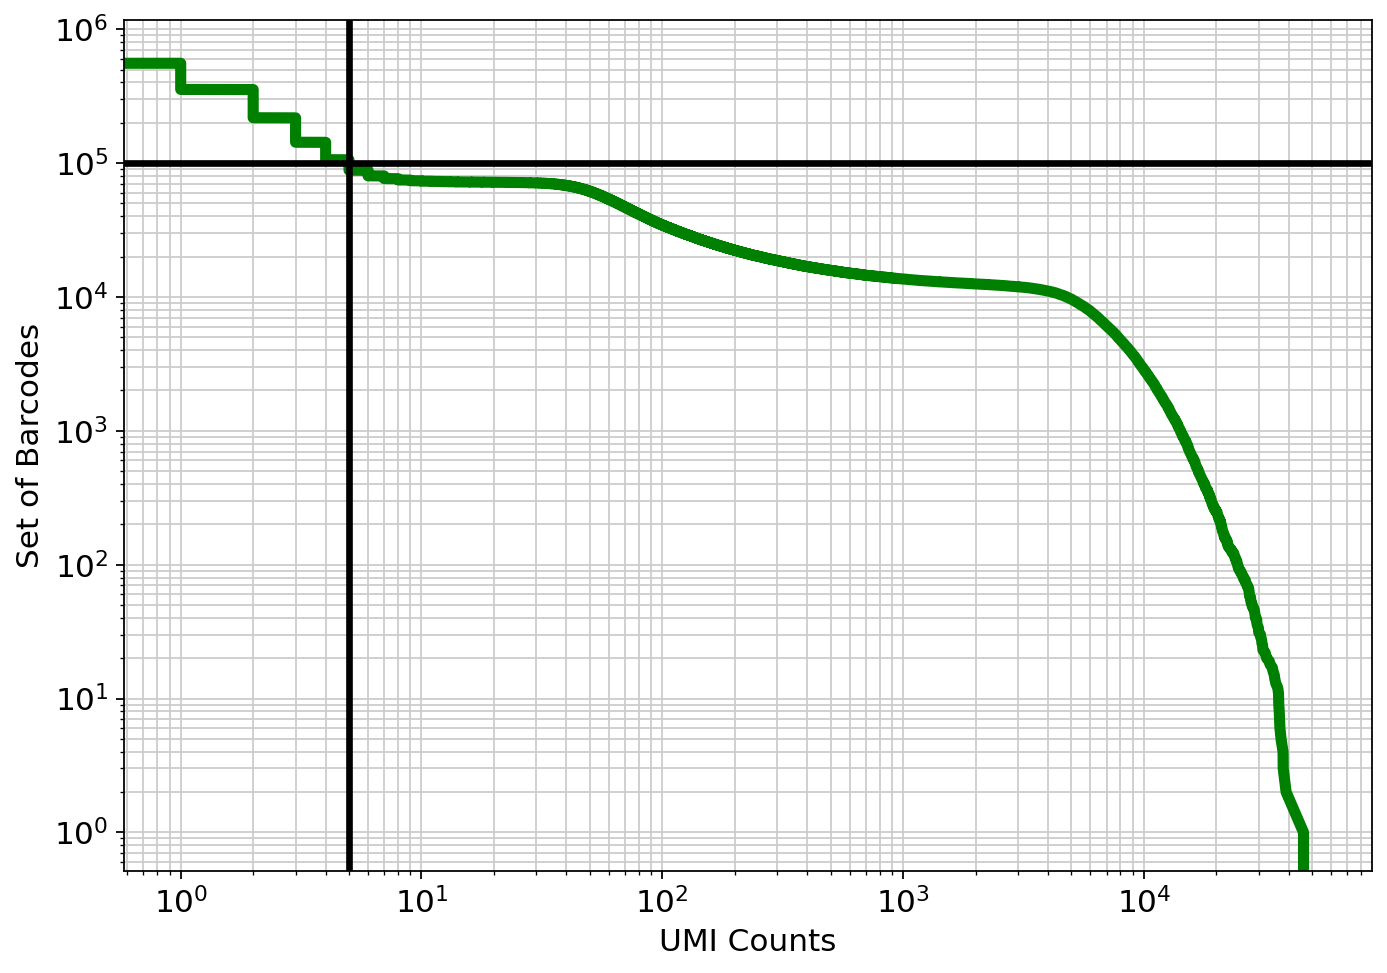

In [76]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  100000#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

####Question 
*Examine the plot and determine where you think the cut-off should be for the mininum number of UMIs that we want per cell.  Set the value of `expected_num_cells` accordingly.  You will use this value again in the section "Filter".*

### Highly Expressed Genes

The last sanity check that we will do before filtering is to look at what genes are most highly expressed in the raw data.  

It is useful e.g. to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) write that

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

We use the scanpy function `sc.pl.highest_expr_genes` to pull out the `n_top` genes that have the highest fraction of counts in a single cell.  This function also visualizes the data.  A point in the plot at, say, 20% in the line for gene Actb means that there is a cell in the dataset where 20% of the reads came from that gene.  

normalizing counts per cell
    finished (0:00:00)


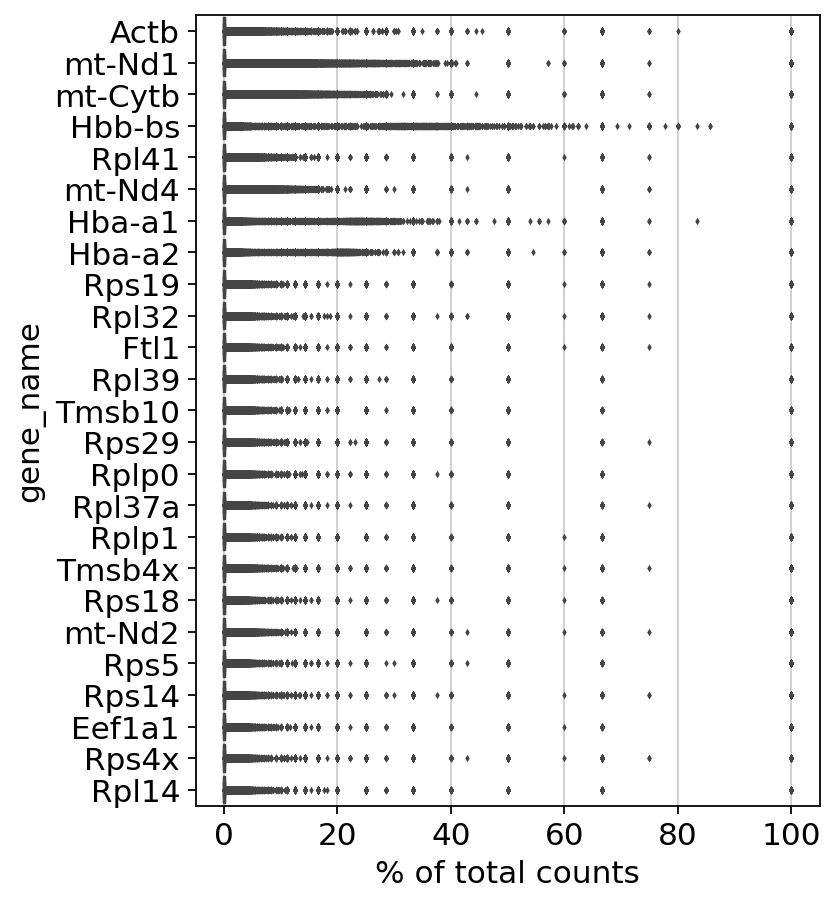

In [77]:
sc.pl.highest_expr_genes(adata, n_top=25)

#### Question
*Look up 3-5 of the top genes and answer whether you would, or would not, expect to see that gene on this list*

Type your answer here:


## Analysis

### Filter

Begin by filtering cells according to various criteria.  We remove cells with 

*  cells with too few UMI counts
*  genes with 0 UMI counts
*  cells with less than 200 expressed genes
*  genes that are expressed in fewer than 3 cells

After each filter with print out the size of our data matrix.

In [78]:
# Print the size of the data matrix at start
adata

AnnData object with n_obs × n_vars = 603685 × 55421
    var: 'gene_id', 'gene_name'

Reset : If you are trying different filtering options you can use the following commands to reset the data to the full data matrix.  Just remove the # at the beginning of each line and then run the commands.

In [0]:
adataOriginal

AnnData object with n_obs × n_vars = 13627 × 55421 
    obs: 'n_counts'
    var: 'gene_id', 'gene_name'

In [0]:
del adata
adata = adataOriginal

adata

adataOriginal

AnnData object with n_obs × n_vars = 13627 × 55421 
    obs: 'n_counts'
    var: 'gene_id', 'gene_name'

**Apply several filters.**


In [79]:
# Removes cells with few UMI counts.  
# Set the number at the end of the line.
#adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) >= 1000]
sc.pp.filter_cells(adata, min_counts=4000)
adata

filtered out 592623 cells that have less than 4000 counts


AnnData object with n_obs × n_vars = 11062 × 55421
    obs: 'n_counts'
    var: 'gene_id', 'gene_name'

In [0]:
del adata
adata = adataOriginal
adata
sc.pp.filter_cells(adata, min_counts=1000)
adata

AnnData object with n_obs × n_vars = 13627 × 55421 
    obs: 'n_counts'
    var: 'gene_id', 'gene_name'

In [80]:
# Removes genes with 0 umi counts
#adata = adata[:, np.asarray(adata.X.sum(axis=0)).reshape(-1) > 0]
sc.pp.filter_genes(adata, min_counts=1)
adata

filtered out 21173 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 11062 × 34248
    obs: 'n_counts'
    var: 'gene_id', 'gene_name', 'n_counts'

In [88]:
# Apply the scanpy function filter_cells to
# remove all cells with fewer than min_genes expressed genes. 
sc.pp.filter_cells(adata, min_genes=2000)
adata


filtered out 1416 cells that have less than 2000 genes expressed


AnnData object with n_obs × n_vars = 9447 × 29607
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'n_counts', 'n_cells'

In [82]:
# Apply the scanpy function filter_genes to
# remove all genes that are present in fewer than min_cells cells.
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 4641 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 10863 × 29607
    obs: 'n_counts', 'n_genes'
    var: 'gene_id', 'gene_name', 'n_counts', 'n_cells'

#### Question

*At each step of the filtering we remove either cells or genes.  Note how the size of the datamatrix changes in each step.  What filter removes the most data?  What filter do you think is most important?*

Type your answer here:

**Add information to our data set**

For each cell we calculate the percent mitochondrial gene content and add this information to our data set.  By convention mitochondrial gene names start with "mt-", which we use in the first line to obtain a list of mitochondrial genes in the data.

In [0]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense 
# array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


We also add to our dataset a variable `n_counts` that contains the total abundance for each cell.

In [0]:
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Print our data object again to confirm that the new variables have been added.

In [85]:
adata

AnnData object with n_obs × n_vars = 10863 × 29607
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'n_counts', 'n_cells'

Perform a QC check of the counts post-filtering

First lets look at the histograms and scatterplots that we made at the outset.

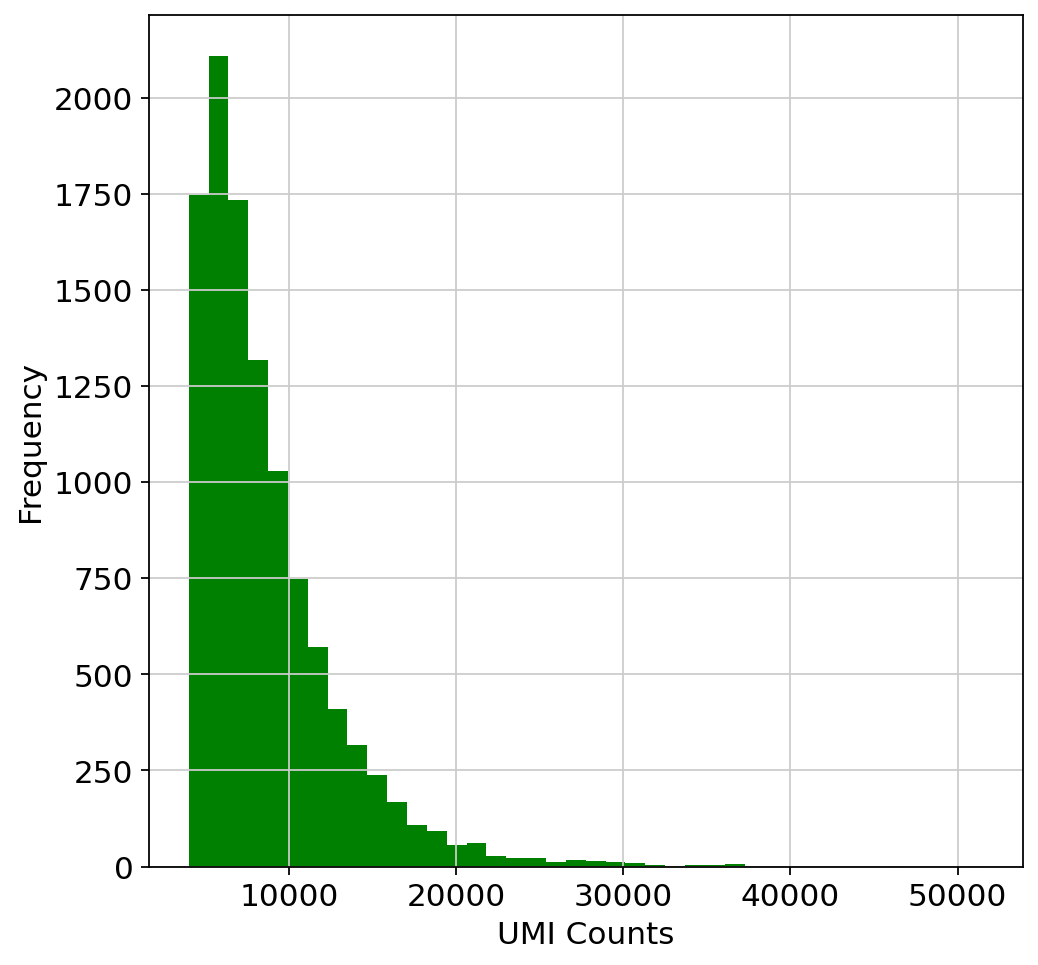

In [86]:
# Histogram of #UMIs per cell.
fig, ax = plt.subplots(figsize=(7, 7))
x = np.asarray(adata.X.sum(axis=1))[:,0]

ax.hist(x, color="green", bins=40)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Frequency")
plt.show()

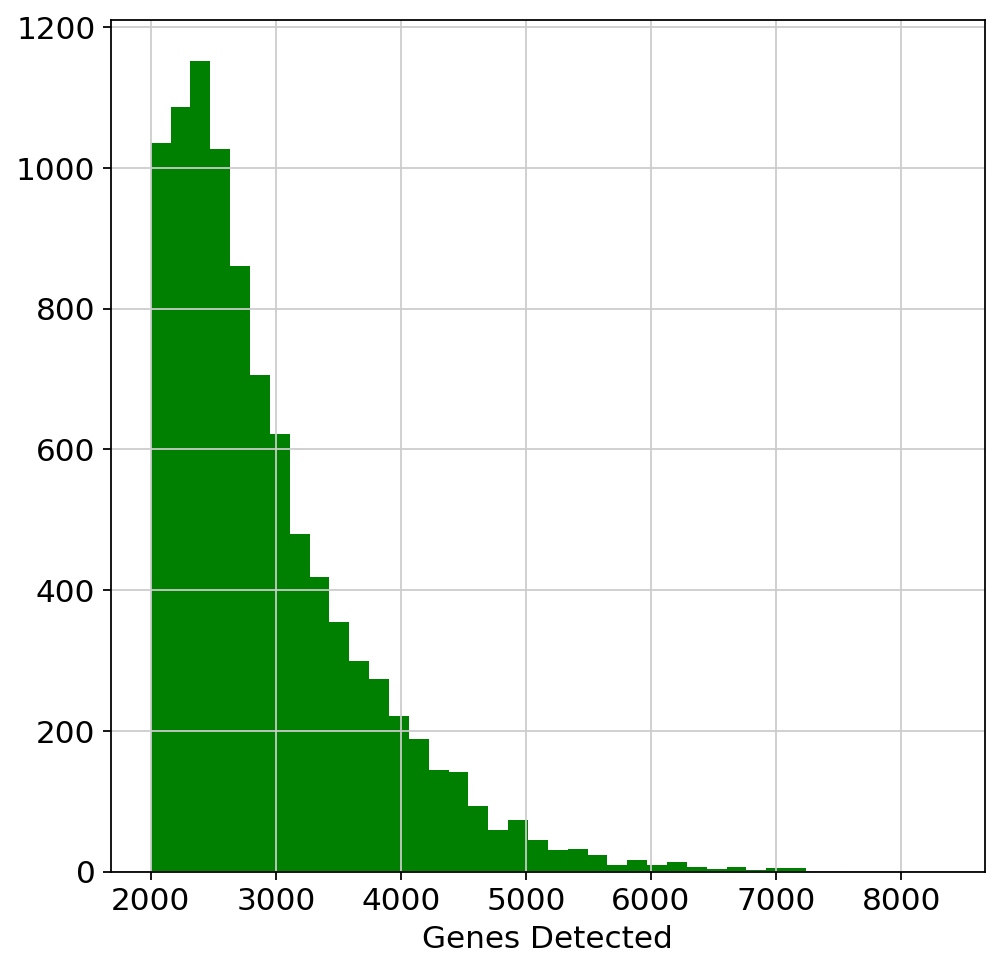

In [89]:
# Histogram of #genes expressed in each cell
fig, ax = plt.subplots(figsize=(7, 7))
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]
ax.hist(y, color="green", bins=40)
ax.set_xlabel("Genes Detected")

plt.show()


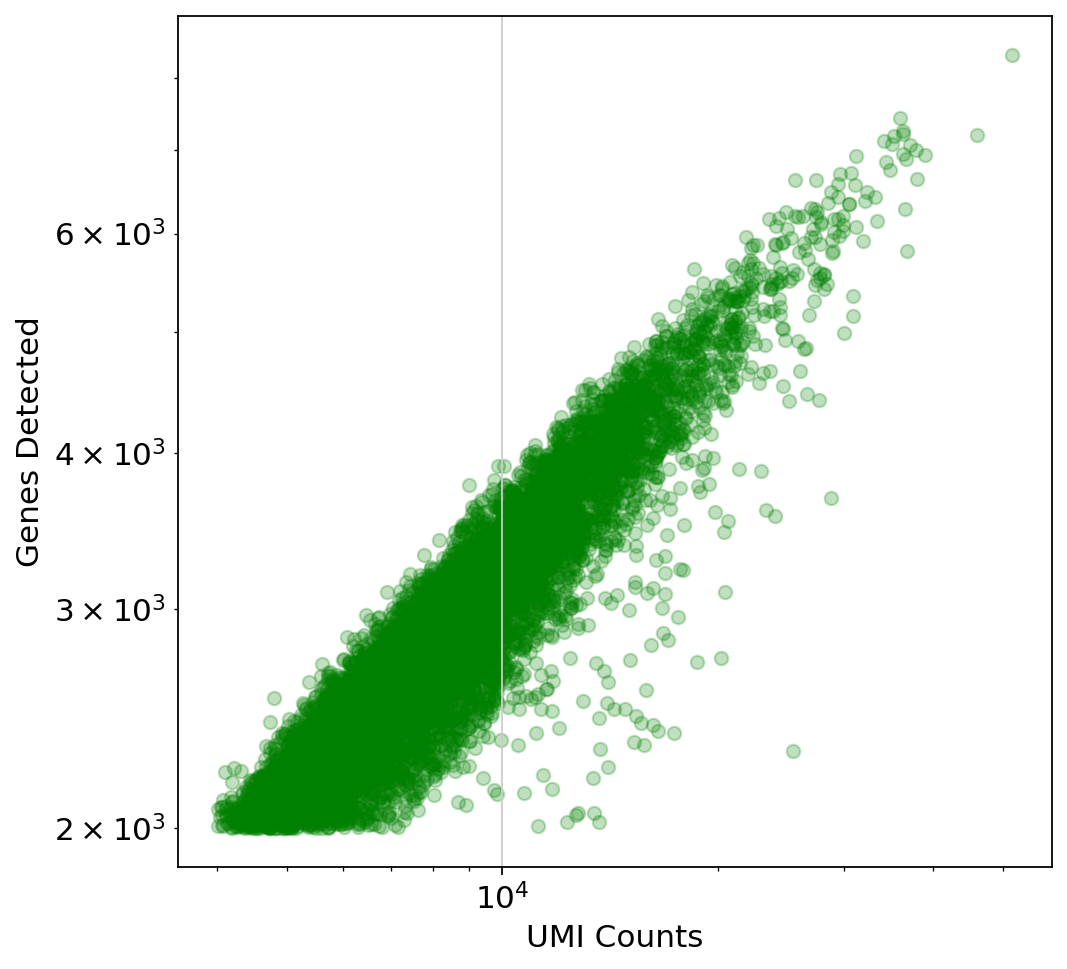

In [90]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(7, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

# alpha is a plotting parameter that determines how
# transluscent the plotting symbols are
ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim(1)
#ax.set_ylim(1)


plt.show()

Now we redo this scatterplot with the `scanpy` scatter function.  Note that the *x* and *y*-axis are now linear, not logarithmic.

... storing 'gene_name' as categorical


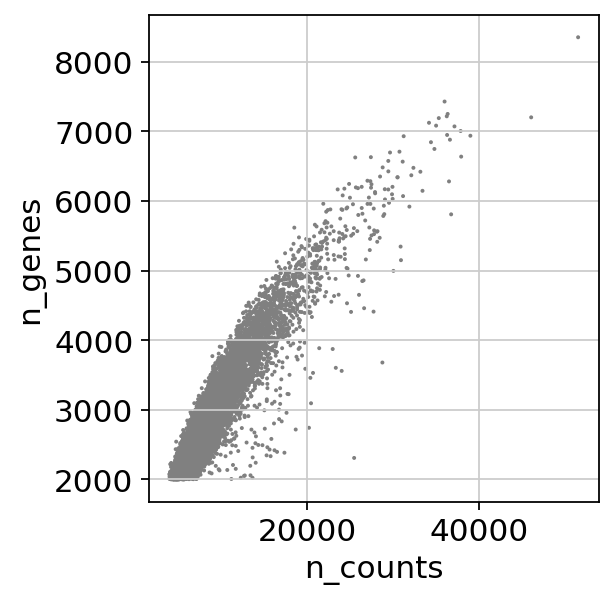

In [91]:
# Now look at n_genes vs. n_counts in the filtered datasets.
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Another way of viewing the data is by looking at violinplots.

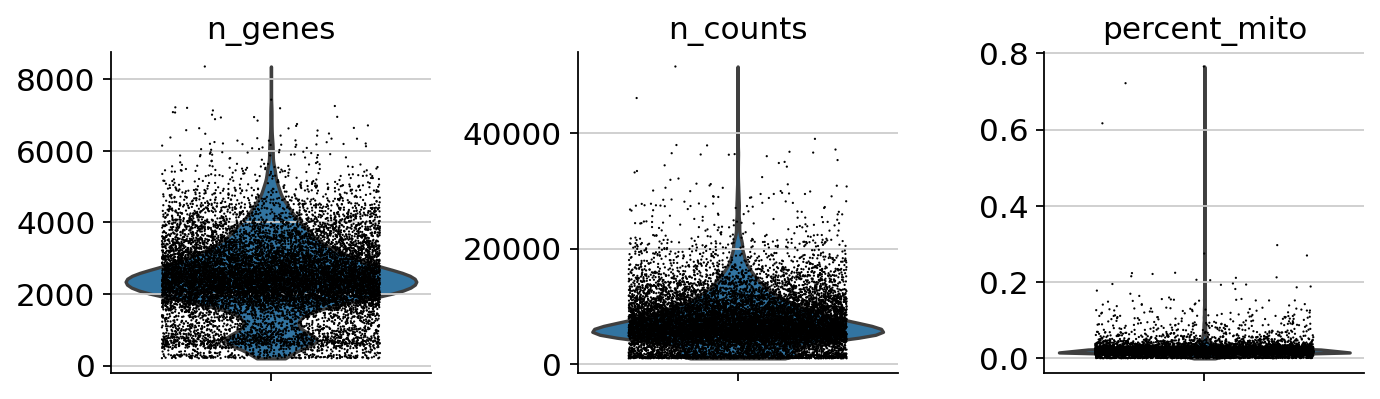

In [0]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter = 0.3, multi_panel=True)

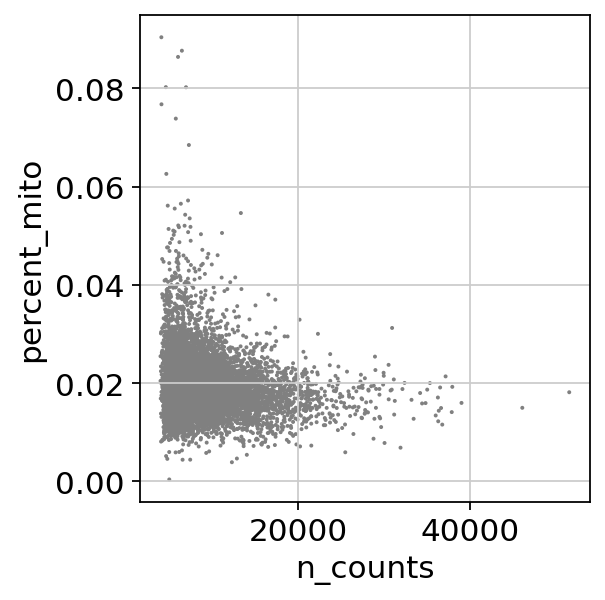

In [92]:
#examine mitochondrial content 
sc.pl.scatter(adata, x='n_counts', y='percent_mito')


In [0]:
# Create a mask to filter out cells with more than 6500 genes, 
# less than 200 genes or less than 0.2 mitochondrial umi counts
mask = np.logical_or((adata.obs.n_genes < 6500).values, 
                     (adata.obs.n_genes > 200).values, 
                     (adata.obs.percent_mito < 0.2).values)

In [0]:
#filter
adata = adata[mask, :]

In [0]:
adata

### Normalize counts

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

(array([2.764e+03, 2.955e+03, 1.660e+03, 9.000e+02, 5.340e+02, 2.690e+02,
        1.470e+02, 8.800e+01, 4.300e+01, 3.000e+01, 2.600e+01, 1.100e+01,
        5.000e+00, 1.000e+01, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 4003.  ,  6378.25,  8753.5 , 11128.75, 13504.  , 15879.25,
        18254.5 , 20629.75, 23005.  , 25380.25, 27755.5 , 30130.75,
        32506.  , 34881.25, 37256.5 , 39631.75, 42007.  , 44382.25,
        46757.5 , 49132.75, 51508.  ], dtype=float32),
 <a list of 20 Patch objects>)

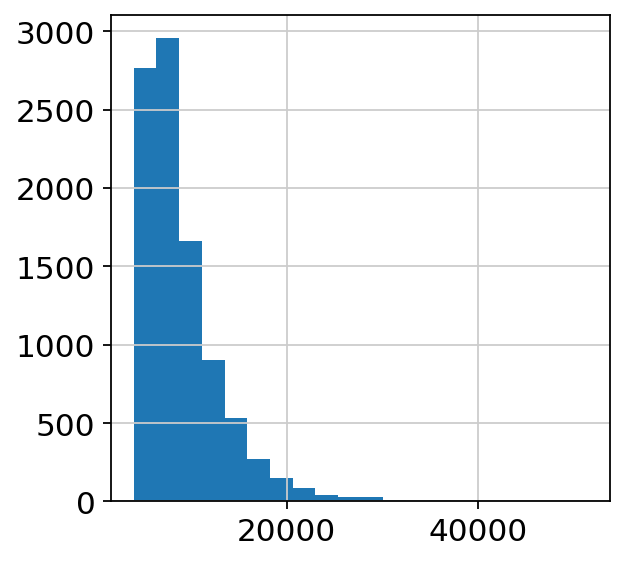

In [93]:
plt.hist(adata.obs['n_counts'], bins=20)

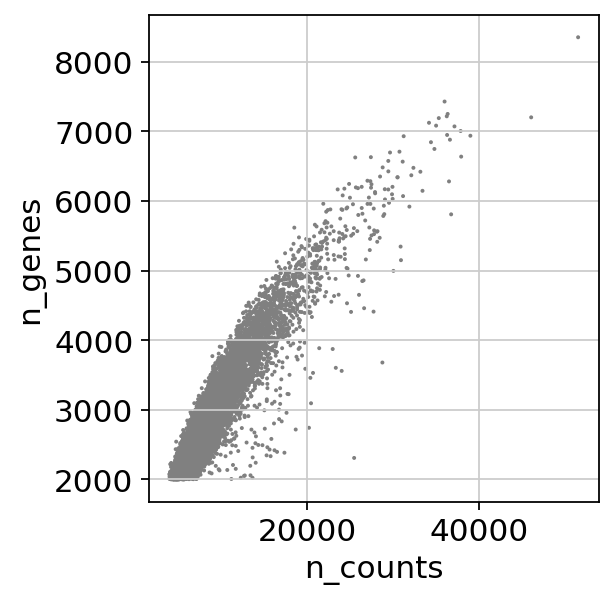

In [95]:
# Now look at n_genes vs. n_counts in the filtered datasets.
sc.pl.scatter(adata, x='n_counts', y='n_genes')


In [96]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata, target_sum=10**4)

normalizing counts per cell
    finished (0:00:00)


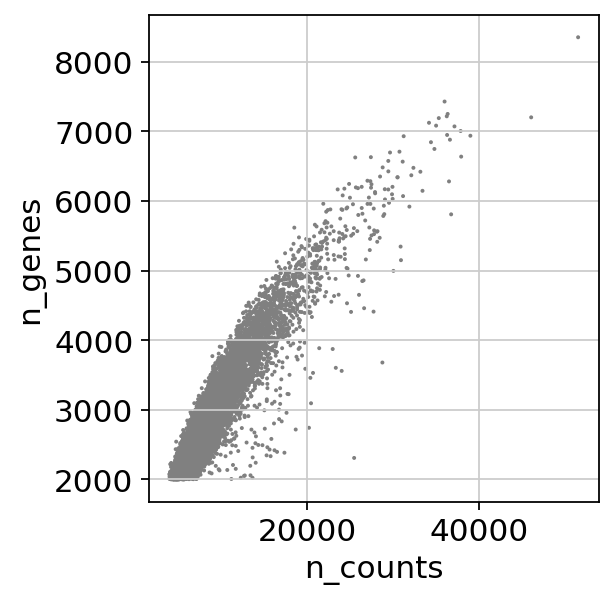

In [97]:
# Now look at n_genes vs. n_counts in the filtered datasets.
sc.pl.scatter(adata, x='n_counts', y='n_genes')

There is a very, very wide range in gene expression values.  Log the counts

In [0]:
#adata.X.min()
#adata.X.max()

In [0]:
# Replace raw counts with their logarithm
sc.pp.log1p(adata)

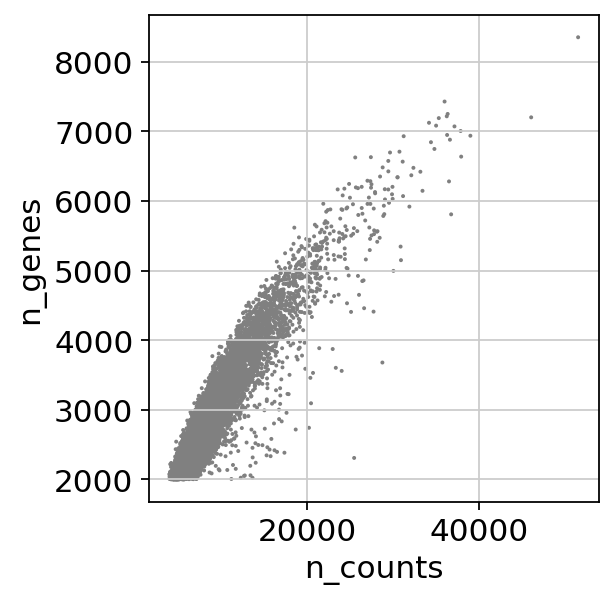

In [99]:
# Now look at n_genes vs. n_counts in the filtered datasets.
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Lets now look at the highest expressed genes after filtering, normalization, and log

normalizing counts per cell
    finished (0:00:00)


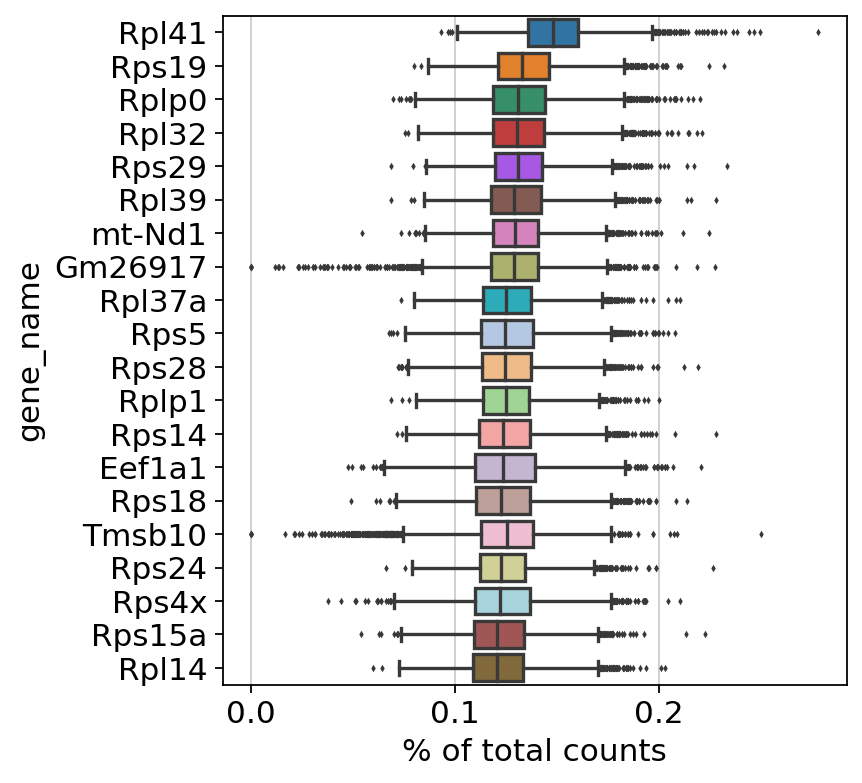

In [100]:
sc.pl.highest_expr_genes(adata, n_top=20)

#### Question
*Describe how this plot compares to the corresponding plot created in "Highly Expressed Genes".  Include a comment on the x-axis and the set of genes.*

Type your answer here: 

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

The unnormalized data is stored in `.raw`.

In [0]:
adata.raw = adata

<div class="alert alert-info">

**Note**
The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools.

</div>

### Identify highly-variable genes.

In [102]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=2000, flavor="cell_ranger", n_bins=20)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


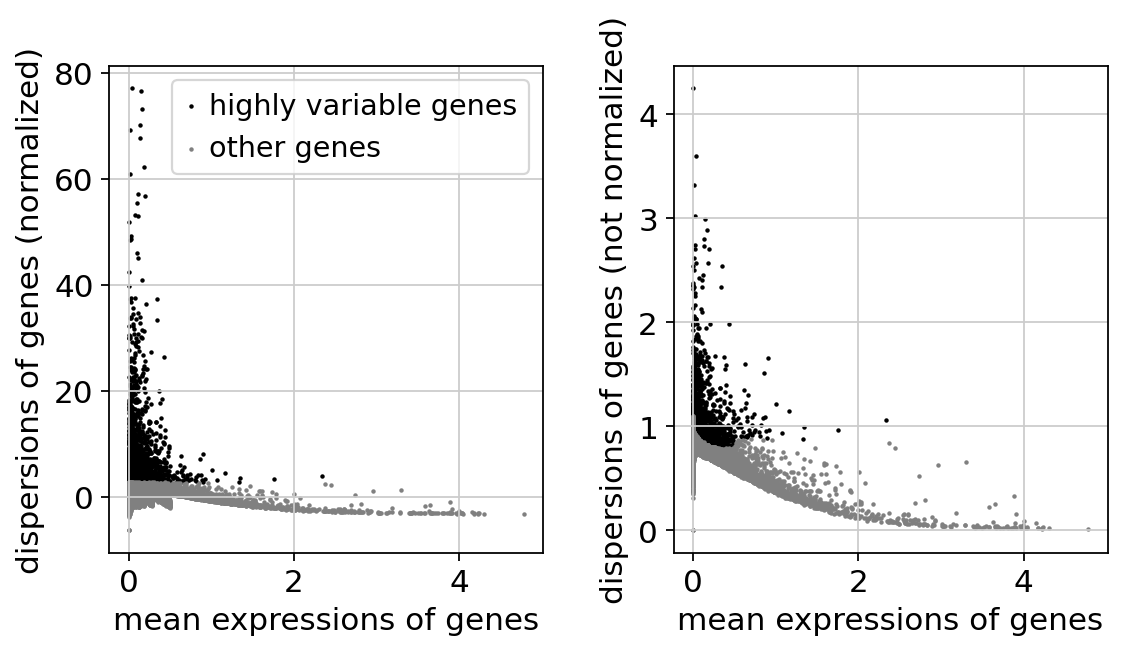

In [103]:
sc.pl.highly_variable_genes(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

We do not regress out as per https://github.com/theislab/scanpy/issues/526

In [0]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

### Scaling the data
Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [104]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [105]:
# We perform PCA on just the highly variable genes
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


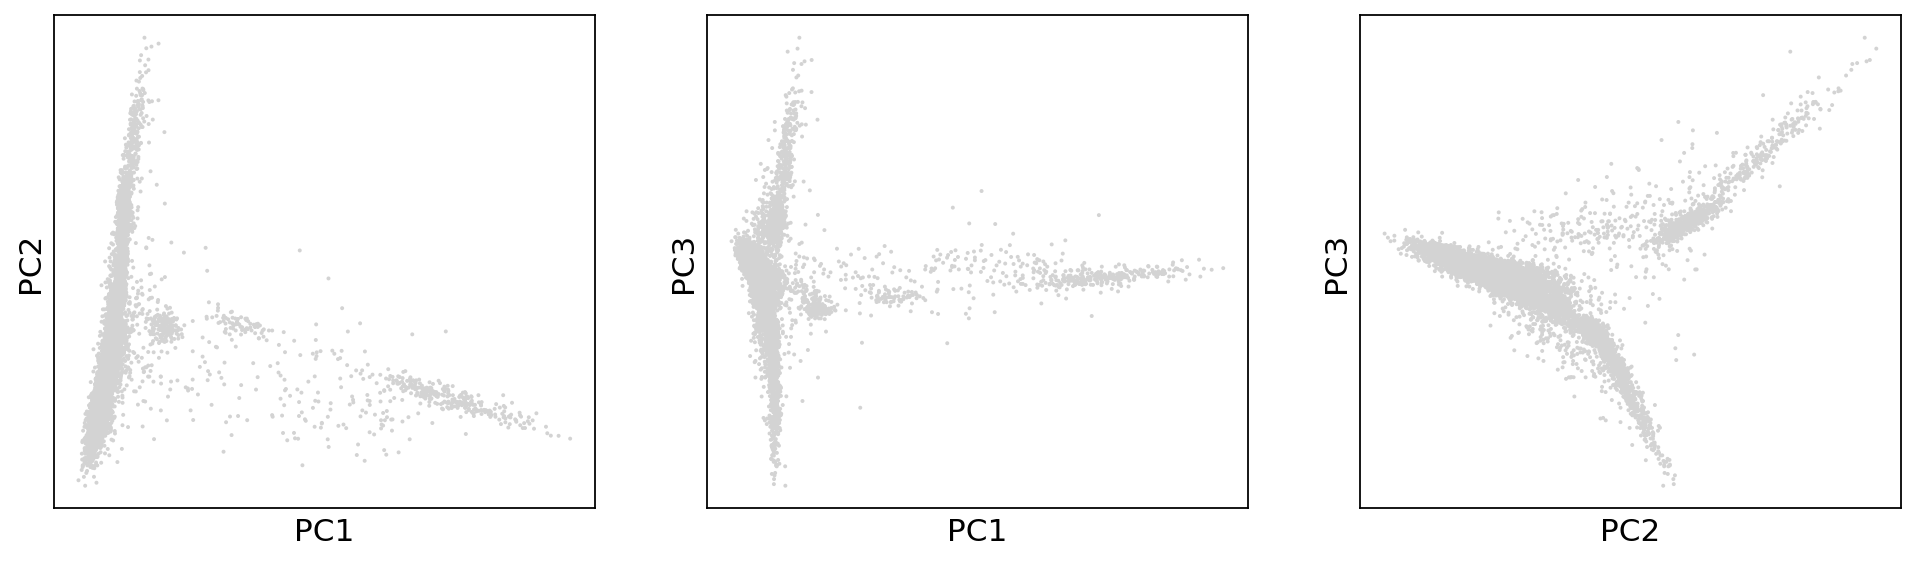

In [108]:
sc.pl.pca(adata, components=['1,2', '1,3', '2,3'])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.leiden()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

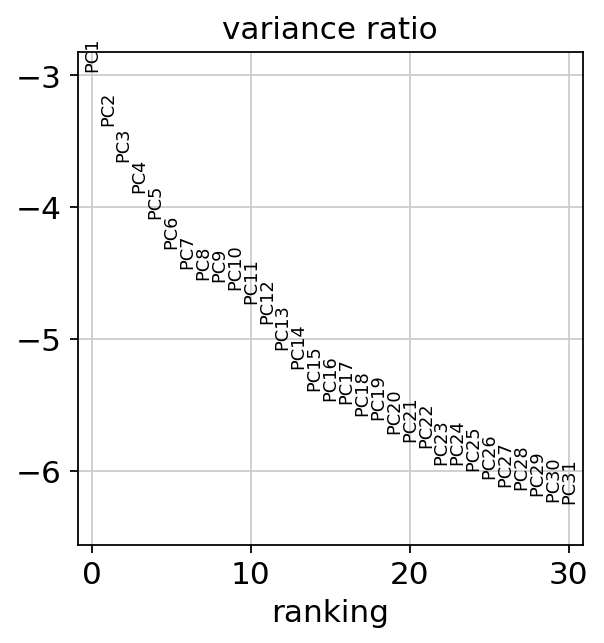

In [109]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result if you'd like.

In [110]:
!mkdir write

mkdir: cannot create directory ‘write’: File exists


In [111]:
adata.write(results_file)

RuntimeError: ignored

In [112]:
adata

AnnData object with n_obs × n_vars = 9447 × 29607
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute the neighborhood graph

Next we compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. In order to be consistent with Seurat's results, we use the following values.

In [113]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


### Embed the neighborhood graph

### UMAP

UMAP (UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction) is a manifold learning technique that can also be used to visualize cells. It was published in:

- McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).

We run that to visualize the results:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [0]:
sc.tl.tsne(adata)

In [0]:
sc.pl.tsne(adata, color=['Myod1'])

### Cluster the neighborhood graph

### Clustering

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Leiden](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in 

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [0]:
sc.tl.leiden(adata, resolution=0.5, random_state=42)

A plot of the clusters is shown below:

In [0]:
sc.pl.tsne(adata, color=['leiden', 'Tnnt2', 'Myod1', 'Neb'])

Save the result.

In [0]:
adata.write(results_file)

### Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Typically the t-test is used for this purpose.

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [0]:
sc.settings.verbosity = 2  # reduce the verbosity

An alternative to the parametric t-test is the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [0]:
adata.write(results_file)

As an alternative, genes can be ranked using logistic regression (see [Natranos et al. (2018)](https://doi.org/10.1101/258566)).

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

We define a list of marker genes for later reference.

In [0]:
marker_genes = ['Tnc', 'Mrln', 'Fst', 'Postn', 'Pclaf', 'Mdk', 'Lum', 'Crip1',
                'Krt5', 'Tnnt2', 'Pf4', 'Fabp4', 'Ftl1',  
                'Dmkn', 'Myl6', 'Dbi', 'Hdc', 'Sox9']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [0]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [0]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster. 

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [0]:
adata = sc.read(results_file)

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

In [0]:
sc.pl.violin(adata, marker_genes, groupby='leiden')

Actually mark the cell types.

In [0]:
sc.pl.tsne(adata, color='leiden', legend_loc='on data', title='', frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

In [0]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='leiden')

There is also a very compact violin plot.

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

Note that as a result of the analysis the adata object has accumulated several annotations:

In [0]:
adata

In [0]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to export to "csv", you have the following options:

In [0]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [0]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb).